In [346]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import json
import pickle

In [347]:
df = pd.read_csv('data/train.csv')
df.shape

(1628, 29)

In [348]:
df.columns

Index(['Id', 'Age', 'Attrition', 'BusinessTravel', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobRole',
       'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'CommunicationSkill',
       'Behaviour'],
      dtype='object')

### Feature Engineering

In [349]:
def extract_feature(df_input):
    df = df_input.copy()
    df['OwnStocks'] = df.StockOptionLevel.apply(lambda x: 'No' if x == 0 else 'Yes')
    df['PropWorkLife'] = df.TotalWorkingYears / df.Age
    df['PropExpComp'] = df.NumCompaniesWorked / (df.TotalWorkingYears+1)
    df['PropRoleComp'] = df.YearsInCurrentRole / (df.YearsAtCompany + 1)
    df['AgeBar'] = pd.cut(df.Age, bins = [0,27,45,np.inf], labels=['Young','Mid','Old']).astype('object')
    q_pays = {
        'Laboratory Technician': 2705.0, 
        'Manufacturing Director': 5824.4000000000015, 
        'Sales Executive': 5675.8, 
        'Research Scientist': 2693.4, 
        'Sales Representative': 2325.8, 
        'Healthcare Representative': 6348.6, 
        'Research Director': 15014.600000000002, 
        'Human Resources': 2741.0, 
        'Manager': 16894.0
    }
    df['AboveQPay'] = df.apply(lambda x: 'No' if x.MonthlyIncome < q_pays.get(x.JobRole) else 'Yes', axis = 1)
    #df['WorkFactors'] = (df.EnvironmentSatisfaction+df.JobSatisfaction+df.JobInvolvement) / 15
    cols_to_drop = [
                    'Id',
                    'Behaviour',
                    'PerformanceRating',
                    'Gender',
                    'Education', 
                    'Department',
                    'EmployeeNumber',
                    'PercentSalaryHike',
                    'YearsInCurrentRole',
                    'YearsSinceLastPromotion',
                    'YearsWithCurrManager',
                    'TrainingTimesLastYear',
                    'EducationField',
                    'StockOptionLevel',
                    'TotalWorkingYears',
                    'YearsAtCompany',
                    'NumCompaniesWorked',
                    'Age',
                    'MonthlyIncome',
                    ]
    df.drop(cols_to_drop, inplace = True, axis = 1)
    print('Columns Dropped : {}'.format(cols_to_drop))
    print('Columns in DataFrame: {}'.format(df.columns.to_list()))
    return df

In [350]:
df_cleaned = extract_feature(df)

Columns Dropped : ['Id', 'Behaviour', 'PerformanceRating', 'Gender', 'Education', 'Department', 'EmployeeNumber', 'PercentSalaryHike', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'TrainingTimesLastYear', 'EducationField', 'StockOptionLevel', 'TotalWorkingYears', 'YearsAtCompany', 'NumCompaniesWorked', 'Age', 'MonthlyIncome']
Columns in DataFrame: ['Attrition', 'BusinessTravel', 'DistanceFromHome', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'OverTime', 'CommunicationSkill', 'OwnStocks', 'PropWorkLife', 'PropExpComp', 'PropRoleComp', 'AgeBar', 'AboveQPay']


In [351]:
df_cleaned.dtypes

Attrition                    int64
BusinessTravel              object
DistanceFromHome             int64
EnvironmentSatisfaction      int64
JobInvolvement               int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
OverTime                    object
CommunicationSkill           int64
OwnStocks                   object
PropWorkLife               float64
PropExpComp                float64
PropRoleComp               float64
AgeBar                      object
AboveQPay                   object
dtype: object

### Preprocessing and Model Building Init

In [352]:
df_cleaned.drop_duplicates(inplace=True)
df_cleaned.shape

(1000, 16)

In [353]:
df_X = df_cleaned.drop(['Attrition'], axis = 1).copy()
df_y = df_cleaned[['Attrition']].copy()

In [354]:
nominal_type = list(df_X.select_dtypes(include='object').columns)
nominal_type

['BusinessTravel',
 'JobRole',
 'MaritalStatus',
 'OverTime',
 'OwnStocks',
 'AgeBar',
 'AboveQPay']

In [355]:
nominal_type_vals = dict()
for ot in nominal_type:
    nominal_type_vals[ot] = list(df_X[ot].unique())
print(nominal_type_vals)

{'BusinessTravel': ['Non-Travel', 'Travel_Rarely', 'Travel_Frequently'], 'JobRole': ['Laboratory Technician', 'Manufacturing Director', 'Sales Executive', 'Research Scientist', 'Sales Representative', 'Healthcare Representative', 'Research Director', 'Human Resources', 'Manager'], 'MaritalStatus': ['Single', 'Married', 'Divorced'], 'OverTime': ['No', 'Yes'], 'OwnStocks': ['No', 'Yes'], 'AgeBar': ['Mid', 'Old', 'Young'], 'AboveQPay': ['No', 'Yes']}


In [356]:
numerical_type = list(df_X.select_dtypes(exclude='object').columns)
numerical_type

['DistanceFromHome',
 'EnvironmentSatisfaction',
 'JobInvolvement',
 'JobSatisfaction',
 'CommunicationSkill',
 'PropWorkLife',
 'PropExpComp',
 'PropRoleComp']

In [357]:
ordinal_type = list()
ordinal_columns_dataset = ['EnvironmentSatisfaction',
                           'JobInvolvement',
                           'JobSatisfaction',
                           'Education',
                           'Behaviour',
                           'CommunicationSkill',
                           'PerformanceRating',
                           'StockOptionLevel',
                          ]
for col in ordinal_columns_dataset:
    if col in numerical_type:
        numerical_type.remove(col)
        ordinal_type.append(col)
        
ordinal_type

['EnvironmentSatisfaction',
 'JobInvolvement',
 'JobSatisfaction',
 'CommunicationSkill']

In [358]:
final_cols = list(df_X.columns)
final_cols

['BusinessTravel',
 'DistanceFromHome',
 'EnvironmentSatisfaction',
 'JobInvolvement',
 'JobRole',
 'JobSatisfaction',
 'MaritalStatus',
 'OverTime',
 'CommunicationSkill',
 'OwnStocks',
 'PropWorkLife',
 'PropExpComp',
 'PropRoleComp',
 'AgeBar',
 'AboveQPay']

In [359]:
numerical_index = list()
nominal_index = list()
ordinal_index = list()

for col in numerical_type:
    numerical_index.append(final_cols.index(col))
for col in nominal_type:
    nominal_index.append(final_cols.index(col))
for col in ordinal_type:
    ordinal_index.append(final_cols.index(col))

In [360]:
print('Numerical Columns')
for i,col in zip(numerical_index, numerical_type):
    print(i, col)
print('='*50)
print('Nominal Columns')
for i,col in zip(nominal_index, nominal_type):
    print(i, col)
print('='*50)
print('Ordinal Columns')
for i,col in zip(ordinal_index, ordinal_type):
    print(i, col)

Numerical Columns
1 DistanceFromHome
10 PropWorkLife
11 PropExpComp
12 PropRoleComp
Nominal Columns
0 BusinessTravel
4 JobRole
6 MaritalStatus
7 OverTime
9 OwnStocks
13 AgeBar
14 AboveQPay
Ordinal Columns
2 EnvironmentSatisfaction
3 JobInvolvement
5 JobSatisfaction
8 CommunicationSkill


In [361]:
df_X.describe()

,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobSatisfaction,CommunicationSkill,PropWorkLife,PropExpComp,PropRoleComp
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,9.145000,2.728000,2.727000,2.745000,3.041000,0.286846,0.281996,0.479683
std,8.120956,1.095087,0.703538,1.085889,1.413973,0.153826,0.299577,0.275793
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,0.179487,0.090909,0.333333
50%,7.000000,3.000000,3.000000,3.000000,3.000000,0.263158,0.181818,0.500000
75%,13.000000,4.000000,3.000000,4.000000,4.000000,0.400000,0.385684,0.666667
max,29.000000,4.000000,4.000000,4.000000,5.000000,0.672727,2.250000,0.875000


In [362]:
from sklearn.preprocessing import OneHotEncoder
encoder_dic = {}
for col in nominal_index:
    enc = OneHotEncoder(categories='auto',drop='first',sparse = False).fit(df_X.iloc[:,[col]])
    encoder_dic[col] = enc

In [363]:
X_train = df_X.copy()
y_train = df_y.copy()

In [364]:
from imblearn.over_sampling import SMOTENC
sampler = SMOTENC(categorical_features= nominal_index + ordinal_index, k_neighbors=3, random_state=0)
X_train, y_train = sampler.fit_resample(X_train, y_train)

In [365]:
X_train.shape

(1686, 15)

In [366]:
for i, enc in encoder_dic.items():
    temp = pd.DataFrame(enc.transform(X_train.iloc[:,[i]]), columns=[ list(df_X.columns)[i]+'_'+colname for colname in list(enc.categories_[0])[1:]]).reset_index()
    X_train = pd.concat( [X_train, temp], axis = 1 )

In [367]:
X_train.drop(nominal_type, inplace=True, axis=1)

In [368]:
final_cols_encoded = X_train.columns.values
final_cols_encoded

array(['DistanceFromHome', 'EnvironmentSatisfaction', 'JobInvolvement',
       'JobSatisfaction', 'CommunicationSkill', 'PropWorkLife',
       'PropExpComp', 'PropRoleComp', 'index',
       'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely',
       'index', 'JobRole_Human Resources',
       'JobRole_Laboratory Technician', 'JobRole_Manager',
       'JobRole_Manufacturing Director', 'JobRole_Research Director',
       'JobRole_Research Scientist', 'JobRole_Sales Executive',
       'JobRole_Sales Representative', 'index', 'MaritalStatus_Married',
       'MaritalStatus_Single', 'index', 'OverTime_Yes', 'index',
       'OwnStocks_Yes', 'index', 'AgeBar_Old', 'AgeBar_Young', 'index',
       'AboveQPay_Yes'], dtype=object)

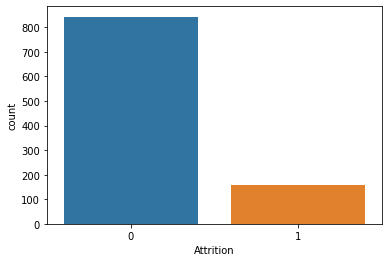

In [369]:
sns.countplot(df_y.Attrition)

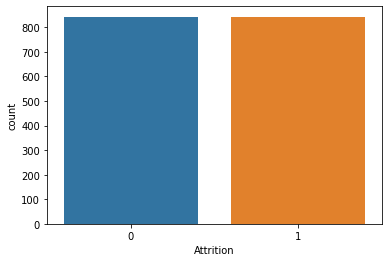

In [370]:
sns.countplot(y_train.Attrition)

In [371]:
X_train, y_train = X_train.values, y_train.values
y_train = y_train.ravel()

In [372]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [373]:
cv = RepeatedStratifiedKFold(n_splits= 5, n_repeats=2, random_state=0)

In [374]:
scores = cross_val_score(RandomForestClassifier(max_features=0.9,n_estimators = 400, oob_score = True, max_depth=7), X_train, y_train, scoring='roc_auc', cv=cv)
scores

array([0.94975666, 0.95769935, 0.95903776, 0.97150606, 0.96446182,
       0.96113581, 0.94864751, 0.96604677, 0.96981544, 0.95586785])

In [375]:
!mkdir models

mkdir: models: File exists


In [376]:
model = RandomForestClassifier(max_features=0.8,n_estimators = 400, oob_score = True, max_depth=7)
model.fit(X_train, y_train)
pkl_filename = "models/Final_RandomForestC.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)